Prerequisite for this notebook:
* `make data/curation/multireader_curation_dataset.pkl`
 * This runs `bioexp_paper/bioexp/curation/group_curations.py` to generate curation dataset pickle files.

In [1]:
# Imports.
import pickle
import random
import itertools
from os.path import join
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
from venn import venn
import matplotlib.pyplot as plt
from indra.tools import assemble_corpus as ac
from bioexp.util import format_axis, fontsize, reader_name_map

import upsetplot

%matplotlib notebook

import matplotlib
matplotlib.rc('font', size=14)

In [2]:
# Load pickle of assembled statements.
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2023-01-22 17:51:34] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2023-01-22 17:52:26] indra.tools.assemble_corpus - Loaded 895580 statements


In [3]:
# Helper functions to save figures and tables
fig_ctr = 0
opath = '../output/'
prefix = 'fig4_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

def save_table(df, name):
    global fig_ctr
    fig_ctr += 1
    filename = join(opath, f'{prefix}_tbl_{fig_ctr}_{name}.xlsx')
    df.to_excel(filename)

In [4]:
# Filter out statements with None agents and those with only DB support.
# The list of readers: 
reader_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']
reader_abbrevs = {'reach': 'R', 'sparser': 'S', 'medscan': 'M',
                  'rlimsp': 'P', 'trips': 'T'}
reader_stmts = []
for stmt in tqdm(all_stmts):
    if None in stmt.agent_list():
        continue
    if not set([ev.source_api for ev in stmt.evidence]).intersection(set(reader_list)):
        pass
    else:
        reader_stmts.append(stmt)
    

100%|██████████| 895580/895580 [00:02<00:00, 299269.65it/s]


In [5]:
len(reader_stmts)

705022

In [6]:
# Load and preprocess the curation dataset.

curation_data_file = '../data/curation/multireader_curation_dataset.pkl'

def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

def binarize_count_data(df):
    # First convert to true/false
    dtype_dict = {col: 'bool' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name',
                                 'agA_ns', 'agA_id', 'stmt_type', 'agB_name',
                                 'agB_ns', 'agB_id')}
    bin_df = df.astype(dtype_dict)
    # Then convert true/false into 1/0
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name',
                                 'agA_ns', 'agA_id', 'stmt_type', 'agB_name',
                                 'agB_ns', 'agB_id')}
    bin_df = bin_df.astype(dtype_dict)
    return bin_df

kge_df = load_curation_data(curation_data_file)
bin_df = binarize_count_data(kge_df)

In [7]:
# Distribution of reader frequencies in corpus and curation data.
# (excluding database only statements)

def reader_set_to_tuple(rset, r_list, r_abbrevs):
    """Converts a frozen set of sources e.g. {reach, sparser} into a tuple 
       of the form (R, S, _, _, _) for use in displaying results."""
    rtup = []
    # Follow the order of readers in reader_list
    for r in r_list:
        if r in rset:
            rtup.append(r_abbrevs[r])
        else:
            rtup.append('_')
    return tuple(rtup)

def get_reader_freq_from_stmts(stmts, source_list, source_abbrevs):
    """Return dictionary showing frequency of reader combinations."""
    all_ev_cts = []
    # Get unique reader evidence sources for each statement
    for stmt in tqdm(stmts):
        sources = frozenset([ev.source_api for ev in stmt.evidence
                       if ev.source_api in source_list])
        if sources:
            all_ev_cts.append(sources)
    # Build up a dictionary mapping the reader combinations (as frozensets) to their
    # frequency in the set of statements
    all_ev_ctr = Counter(all_ev_cts)
    #all_ev_ctr_list = sorted([(k, (v / len(all_ev_cts)))
    #                          for k, v in all_ev_ctr.items()], key=lambda x: x[1], reverse=True)
    all_ev_ctr_dict = {reader_set_to_tuple(k, source_list, source_abbrevs):
                       (v / len(all_ev_cts)) for k, v in all_ev_ctr.items()}
    return all_ev_ctr_dict

def get_reader_counts_from_stmts(stmts):
    """Get a dataframe with source counts for each statement."""
    data = []
    for stmt in tqdm(stmts):
        ev_dict = dict(Counter([ev.source_api for ev in stmt.evidence]))
        ev_dict['stmt_hash'] = stmt.get_hash()
        ev_dict['stmt_type'] = stmt.__class__.__name__
        ev_dict['agA_name'] = stmt.agent_list()[0].name
        if len(stmt.agent_list()) == 2:
            ev_dict['agB_name'] = stmt.agent_list()[1].name
        else:
            continue
        data.append(ev_dict)
    df = pd.DataFrame(data).fillna(0)
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name')}
    return df.astype(dtype_dict)

def get_reader_freq_from_curation(df, col_list, r_abbrevs=None):
    """Build up dictionary of the proportions of each evidence combination in the
       curation dataset. Also return a mapping between the unique evidence combo
       and a dataframe with the curated statements for that combination."""
    if r_abbrevs is None:
        r_abbrevs = {c: c for c in col_list}
    df_ev_dict = {}
    total_rows = df.shape[0]
    df_subgroup_dict = {}
    for gb_key, gb_df in df.groupby(by=col_list):
        freq = (gb_df.shape[0] / total_rows) # Proportion of rows from this group
        label_set = frozenset([col for ix, col in enumerate(col_list)
                               if gb_key[ix] == 1])
        label_tup = reader_set_to_tuple(label_set, col_list, r_abbrevs)
        df_ev_dict[label_tup] = freq
        df_subgroup_dict[label_tup] = gb_df
    return (df_ev_dict, df_subgroup_dict)

def make_df(d, index_name, colname):
    """Build dataframe from a dictionary with dict keys as the index."""
    index, raw_cols = zip(*d.items())
    cols = tuple([c for c in raw_cols])
    index_obj = pd.Index(index, name=index_name, tupleize_cols=False)
    return pd.DataFrame(cols, columns=[colname], index=index_obj)

# -- reader_counts --
# Dataframe for statements with source counts for each statement in the corpus
reader_counts = get_reader_counts_from_stmts(reader_stmts)

# -- freq_df --
# A key result here is the freq_df, which gives the distribution of different reader
# combinations both in the whole corpus as well as in the curated dataset.

# First we need to get the reader/source frequencies (not counts!) from the statements:
reader_freqs = get_reader_freq_from_stmts(reader_stmts, reader_list, reader_abbrevs)
# We also want these for the curated statements to understand curation data bias
curation_freqs, curation_dfs = get_reader_freq_from_curation(bin_df, reader_list, reader_abbrevs)
# Make these into dataframes
stmt_freq_df = make_df(reader_freqs, 'Readers', 'Corpus Freq.')
cur_freq_df = make_df(curation_freqs, 'Readers', 'Curation Freq.')
# Join the above dataframes to make a single combined dataframe
freq_df = stmt_freq_df.join(cur_freq_df).sort_values('Corpus Freq.', ascending=False).fillna(0)
# Save and display
save_table(freq_df, 'freq')
freq_df

100%|██████████| 705022/705022 [00:01<00:00, 391481.60it/s]


,Corpus Freq.,Curation Freq.
Readers,,
"(R, _, _, _, _)",0.449950,0.127820
"(_, _, M, _, _)",0.201791,0.086466
"(_, S, _, _, _)",0.153938,0.031579
"(R, _, M, _, _)",0.078537,0.111278
"(R, S, _, _, _)",0.049878,0.072180
"(R, S, M, _, _)",0.028466,0.101504
"(_, S, M, _, _)",0.010037,0.015038
"(R, S, M, _, T)",0.005133,0.126316
"(_, _, _, _, T)",0.004401,0.046617


In [8]:
weights_df = freq_df['Corpus Freq.'] / freq_df['Curation Freq.']
weights_df.to_pickle('curation_inc_wts.pkl')

INFO: [2023-01-22 17:52:54] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2023-01-22 17:52:54] numexpr.utils - NumExpr defaulting to 8 threads.


Generate data for reader overlap plots:

In [9]:
def stmts_by_source(stmts, source_list):
    """Get {reader: [stmt_uuids]} for all stmts and sources in source_list.
    
    Used to generate Venn diagram and UpSet plot.
    """
    reader_uuids = {}
    for stmt in stmts:
        stmt_sources = frozenset([
            reader_name_map[ev.source_api] for ev in stmt.evidence
            if ev.source_api in source_list])
        # Skip statements with no sources in the given list
        if not stmt_sources:
            continue
        for source in stmt_sources:
            if source not in reader_uuids:
                reader_uuids[source] = set()
            reader_uuids[source].add(stmt.uuid)
    return reader_uuids

uuids_by_source = stmts_by_source(reader_stmts, reader_list)

Venn diagram of reader overlap:

<IPython.core.display.Javascript object>


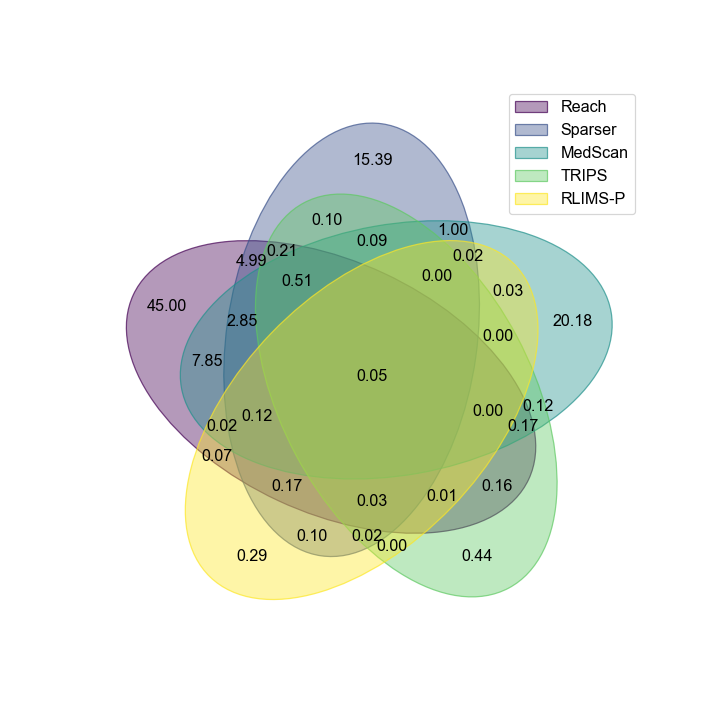

In [10]:
source_venn_subplot = venn(uuids_by_source, fmt='{percentage:.2f}')
source_venn_subplot.figure.savefig(fig_path('overlap_venn_pcts', 'pdf'))

Make an UpSet plot of the same data (both linear and log scale):

<IPython.core.display.Javascript object>


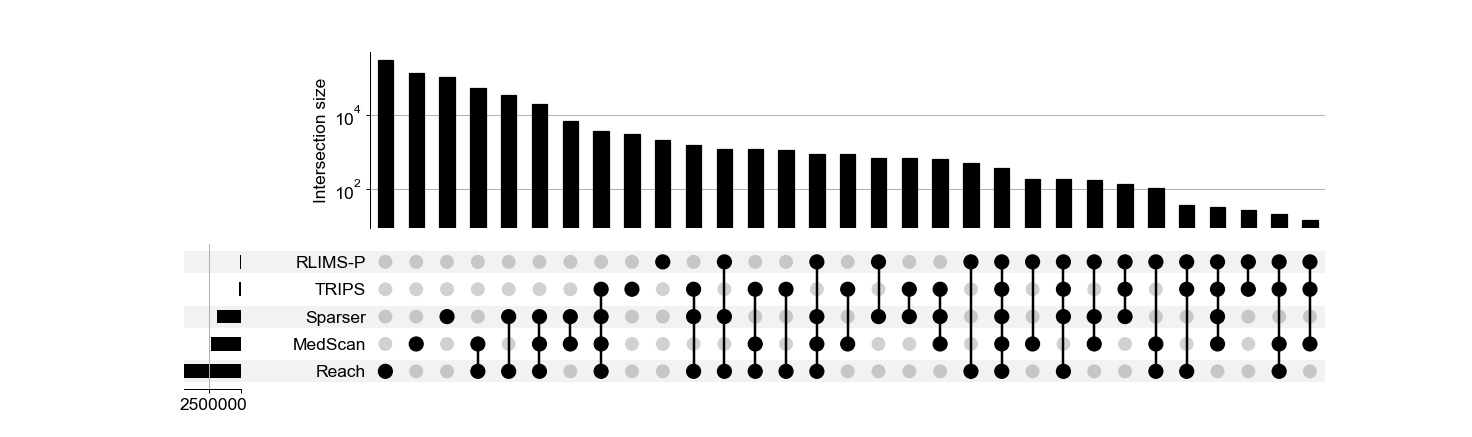

In [11]:
upset_df = upsetplot.from_contents(uuids_by_source)
upset_fig = plt.figure()
upsetplot.plot(upset_df, fig=upset_fig, sort_by='cardinality')
# Plot a linear scale version
upset_fig.savefig(fig_path('overlap_upset_linear', 'pdf'))
# Plot a log scale version
upset_fig.gca().set_yscale('log')
upset_fig.savefig(fig_path('overlap_upset_log', 'pdf'))

In [12]:
# Table 4: Frequencies of relations in corpus by total number of sources.
def marginal_reader_freqs(freqs):
    rcount_dict = {}
    for rtup, freq in freqs.items():
        # Count the number of readers in the freq key tuple
        # Make a set, then turn into a string, then replace'_' with nothing
        rstr = ''.join(set(rtup)).replace('_', '')
        rcount = len(rstr)
        if rcount not in rcount_dict:
            rcount_dict[rcount] = 0
        rcount_dict[rcount] += freq
    return rcount_dict

rcount_dict = marginal_reader_freqs(reader_freqs)
overlap_freq_df = make_df(rcount_dict, 'Num. readers', 'Freq.')
save_table(overlap_freq_df, 'overlap_freq')
overlap_freq_df

,Freq.
Num. readers,
1,0.813014
2,0.144215
3,0.035539
4,0.006722
5,0.000509


### Correlations among readers at the mention and relation levels

In [13]:
# Table 5. Correlations among readers in mention counts.
mention_corrs = reader_counts[reader_list].corr()
save_table(mention_corrs, 'mention_corrs')
mention_corrs

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,0.610648,0.632608,0.071888,0.373680
sparser,0.610648,1.000000,0.453898,0.113957,0.419828
medscan,0.632608,0.453898,1.000000,0.033821,0.337839
rlimsp,0.071888,0.113957,0.033821,1.000000,0.095912
trips,0.373680,0.419828,0.337839,0.095912,1.000000


<IPython.core.display.Javascript object>


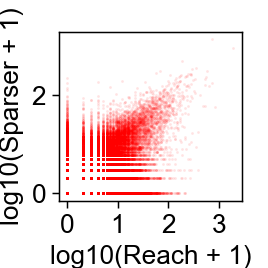

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


In [14]:
# Figure 5B: Scatter plot of mention counts from Reach and Sparser.
def rand_jitter(arr, jitter=0.01):
    stdev = jitter * (max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def reader_corr_plot(count_df, reader1, reader2, jitter=0.01, logscale=True):
    fig = plt.figure(figsize=(2, 2), dpi=150)
    #kge_cp  = count_df[(kge_df[reader1] > 0) | (kge_df[reader2] > 0)]
    if logscale:
        r1_counts = np.log10(count_df[reader1] + 1)
        r2_counts = np.log10(count_df[reader2] + 1)
        xlabel = f'log10({reader_name_map[reader1]} + 1)'
        ylabel = f'log10({reader_name_map[reader2]} + 1)'        
    else:
        r1_counts = count_df[reader1].values
        r2_counts = count_df[reader2].values
        xlabel = reader1
        ylabel = reader2    
    plt.plot(rand_jitter(r1_counts, jitter),
             rand_jitter(r2_counts, jitter), linestyle='', marker='.', markersize=1,
             color='red', alpha=0.1, label='Correct')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.subplots_adjust(left=0.22, bottom=0.25)
    plt.xticks([0, 1, 2, 3])
    #plt.legend(loc='upper left', frameon=False)
    #plt.figtext(0.5, 0.01, "A figure legend.", wrap=True, horizontalalignment='center', fontsize=14)
    #plt.show()
    return fig
    
fig = reader_corr_plot(reader_counts, 'reach', 'sparser', jitter=0, logscale=True)
fig.savefig(fig_path('reach_sparser_corrs', 'png'))


<IPython.core.display.Javascript object>


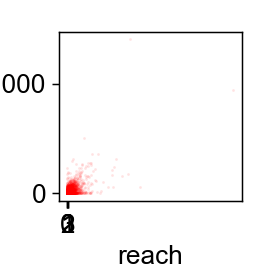

<IPython.core.display.Javascript object>


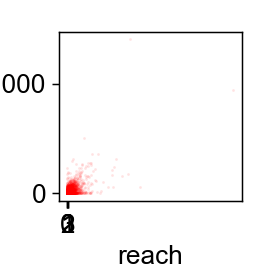

In [15]:
reader_corr_plot(reader_counts, 'reach', 'sparser', jitter=0, logscale=False)

<IPython.core.display.Javascript object>


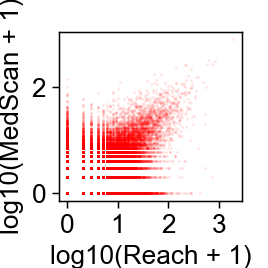

In [16]:
# Figure 5B: Reach vs. Medscan mentions
fig = reader_corr_plot(reader_counts, 'reach', 'medscan', jitter=0, logscale=True)
fig.savefig(fig_path('reach_medscan_corrs', 'png'))

In [17]:
# Table: Mention correlations after filtering out two outlying points with many mentions.
outliers = reader_counts[reader_counts['sparser'] > 800]
outlier_filt = reader_counts.drop(outliers.index)
outlier_filt[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,0.550781,0.548421,0.080636,0.325913
sparser,0.550781,1.000000,0.364867,0.132939,0.332754
medscan,0.548421,0.364867,1.000000,0.037220,0.290822
rlimsp,0.080636,0.132939,0.037220,1.000000,0.100157
trips,0.325913,0.332754,0.290822,0.100157,1.000000


<IPython.core.display.Javascript object>


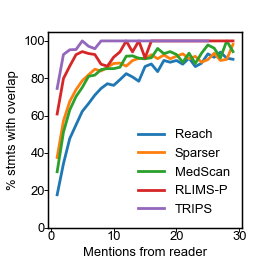

In [18]:
# Figure 5C: Reader overlap as a function of mentions.
def plot_joint_vs_reader_count(count_df, reader_list):
    fig = plt.figure(figsize=(2, 2), dpi=150)
    for reader in reader_list:
        count_df = reader_counts
        other_readers = [r for r in reader_list if r != reader]
        x_vals = []
        y_vals = []
        for reader_count in range(1, 30):
            recs_for_count = count_df[count_df[reader] == reader_count]
            if recs_for_count.shape[0] == 0:
                continue
            x_vals.append(reader_count)
            y_vals.append(100*recs_for_count[other_readers].any(1).mean())
        plt.plot(x_vals, y_vals, label=reader_name_map[reader])
    plt.xlabel(f'Mentions from reader')
    plt.ylabel(f'% stmts with overlap')
    plt.legend(loc='lower right', frameon=False, fontsize=fontsize)
    plt.ylim(0, 105)
    ax = plt.gca()
    format_axis(ax)
    plt.subplots_adjust(left=0.18, bottom=0.15)
    return fig

fig = plot_joint_vs_reader_count(reader_counts, reader_list)
fig.savefig(fig_path('overlap_vs_mentions', 'pdf'))

Note: When mention counts were ignored and only the binary presence/absence of reader support was considered, correlations were small or moderately negative, because the readers contribute separately to the overall corpus but with little overlap on average (Table 5; also Table 1, Figure 1). This is most easily understood for the simplest case of a corpus with output from only two readers, where all correlations would be less than or equal to zero. If the readers were fully complementary (one reader yielding 1 for the other's 0 and vice versa) the correlation would clearly be -1; on the other hand, if the readers were in total agreement (produced identical output), the dataset would contain no zeros at all (because the corpus contains only relations with support from at least one reader) and hence the variances, covariances and correlations would all be zero.

In our dataset with five readers, the readers which produced the majority of the relations (Reach, Sparser, and Medscan) had only negative correlations with each other, because the majority of their output was supported by one or two mentions (Table 6), and lacked overlap with other readers. RLIMS-P and TRIPS exhibited positive correlations with other readers at the relation level, due to the fact that a large proportion of their overall smaller number of extractions overlapped with extractions from other readers (Table 7).

In [19]:
# Table: Correlations among readers at the relation level
bin_reader_counts = binarize_count_data(reader_counts)
bin_reader_counts[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,-0.241753,-0.474403,-0.020938,-0.015515
sparser,-0.241753,1.000000,-0.128048,0.078555,0.111548
medscan,-0.474403,-0.128048,1.000000,-0.010978,0.047709
rlimsp,-0.020938,0.078555,-0.010978,1.000000,0.069556
trips,-0.015515,0.111548,0.047709,0.069556,1.000000


In [20]:
# Table: Proportion of relations from each reader with 1 or >1 mentions.
def one_or_more_mentions(reader_counts, reader_list):
    nz = reader_counts[reader_list].apply(lambda x: x > 0, axis=0).sum()
    one = reader_counts[reader_list].apply(lambda x: x == 1, axis=0).sum()
    multi = reader_counts[reader_list].apply(lambda x: x > 1, axis=0).sum()
    one_ser = one / nz
    multi_ser = multi / nz
    one_ser.name = '=1 mention'
    multi_ser.name = '>1 mentions'
    return pd.concat([one_ser, multi_ser], axis=1)

one_or_more_mentions(reader_counts, reader_list)

,=1 mention,>1 mentions
reach,0.675077,0.324923
sparser,0.618371,0.381629
medscan,0.711481,0.288519
rlimsp,0.636058,0.363942
trips,0.833957,0.166043


In [21]:
# Table: Proportion of relations with overlap with other readers
def overlap_or_not(reader_counts, reader_list):
    col_names = ["No overlap", "Overlap"]
    no_ovl_data = []
    ovl_data = []
    for reader in reader_list:
        other_readers = [r for r in reader_list if r != reader]
        r_df = reader_counts[reader_counts[reader] != 0]
        overlap_pct = r_df[other_readers].any(1).mean()
        ovl_data.append(overlap_pct)
        no_ovl_data.append(1 - overlap_pct)
    return pd.DataFrame(zip(no_ovl_data, ovl_data), index=reader_list, columns=col_names)

overlap_or_not(reader_counts, reader_list)

,No overlap,Overlap
reach,0.724879,0.275121
sparser,0.501262,0.498738
medscan,0.610968,0.389032
rlimsp,0.300823,0.699177
trips,0.222587,0.777413


### Relation correctness as a function of reader overlap

<IPython.core.display.Javascript object>


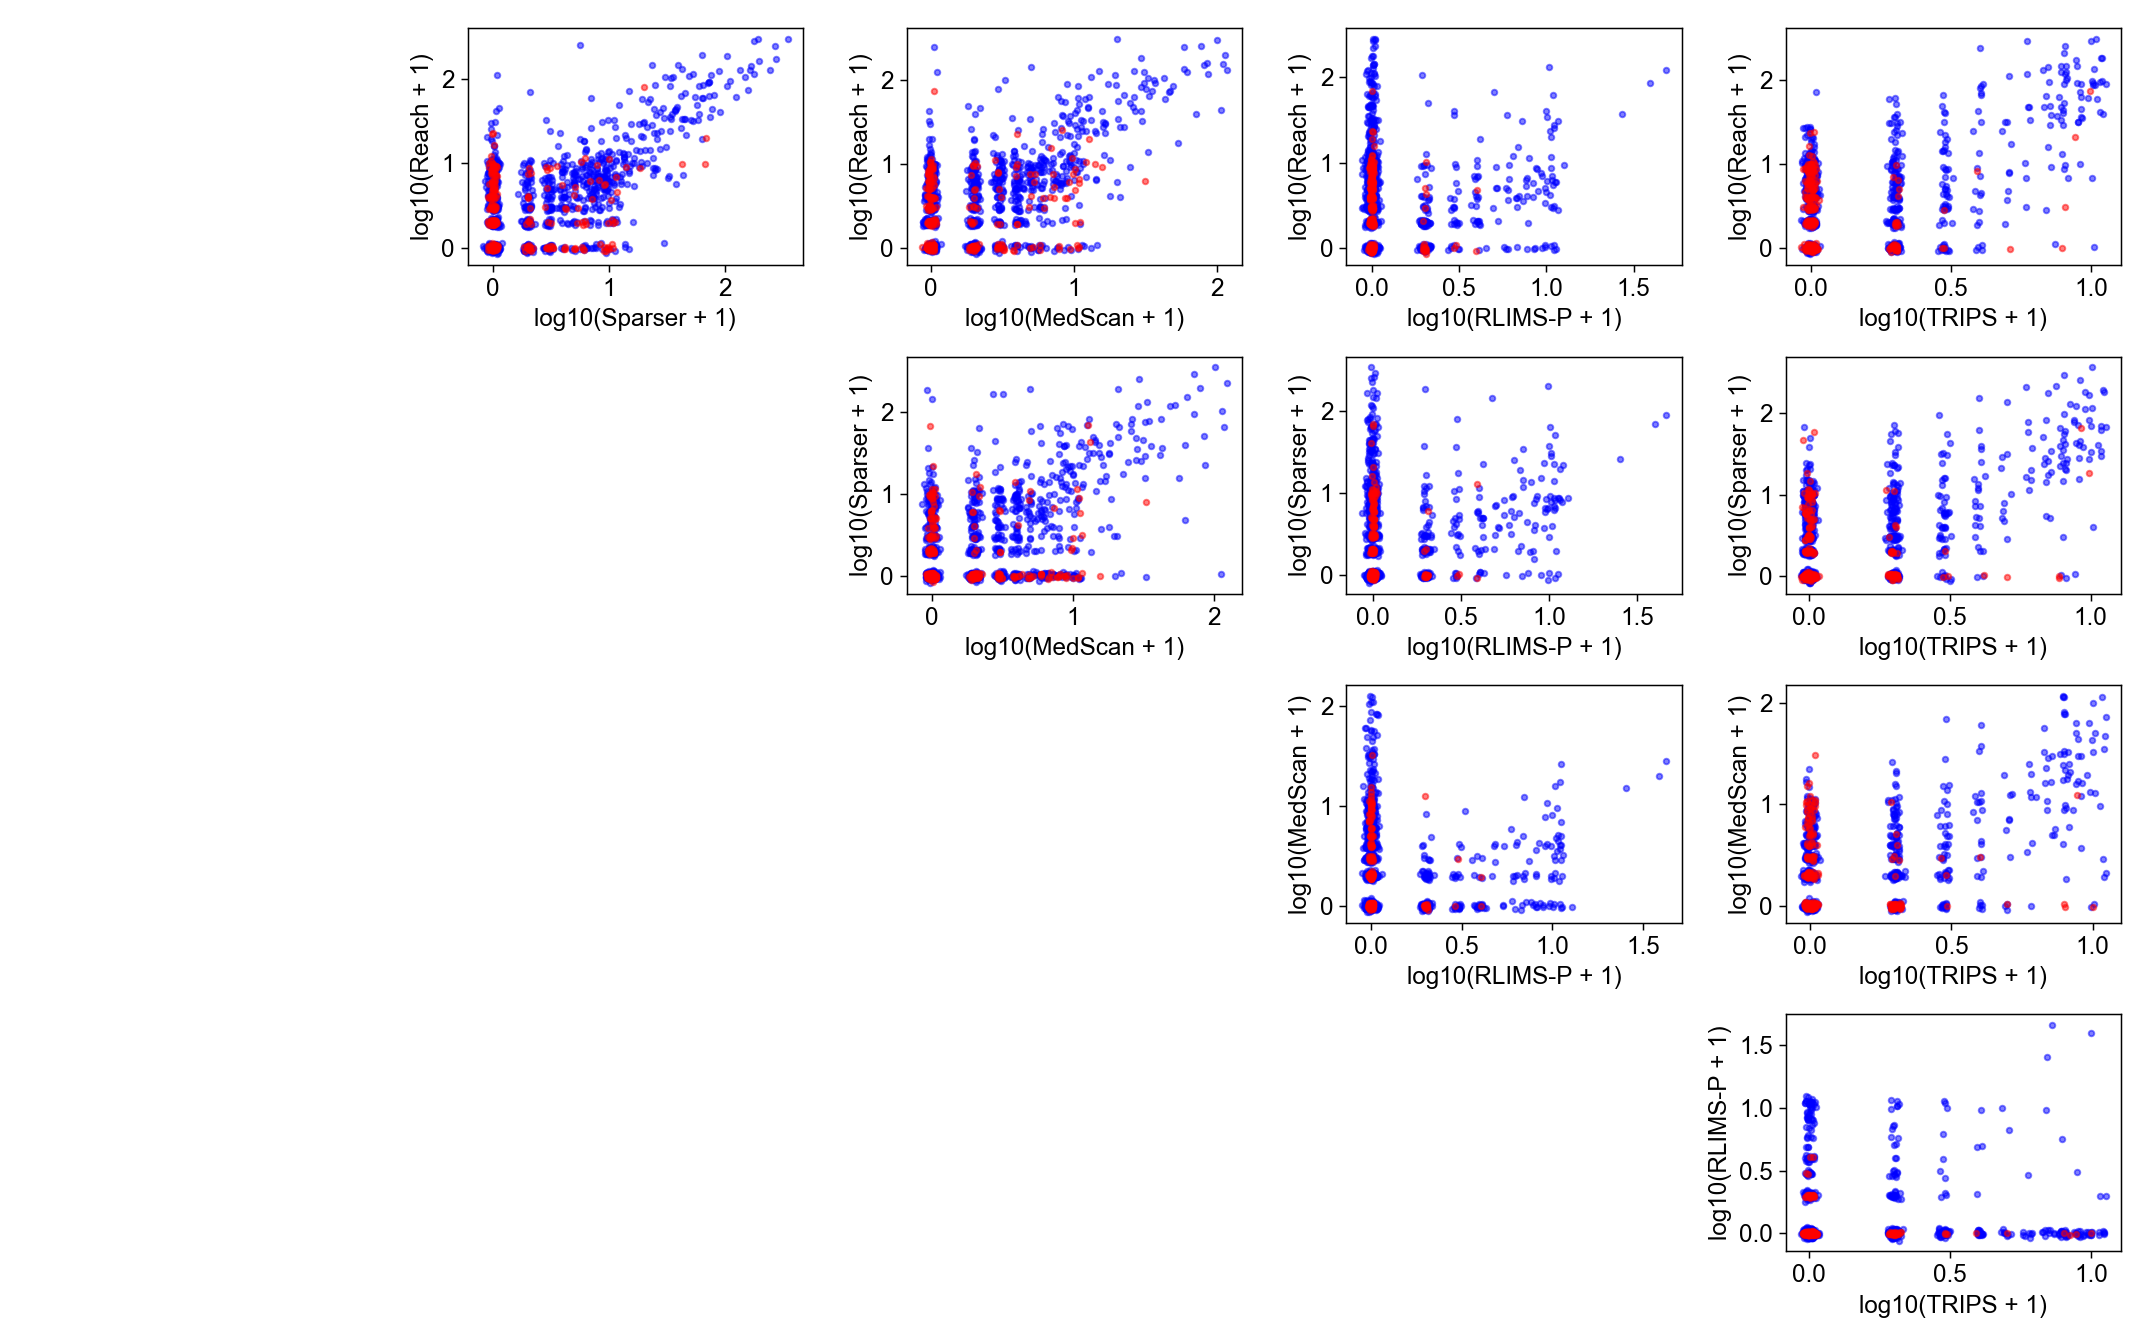

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/si

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


In [22]:
# Figure EV5B: Statement overlap at mention level and probability of correctness.
def plot_overlap_correctness(count_df, readers):
    fontsize=13
    r_pairs = list(itertools.product(readers, readers))
    plotted = set()
    fig = plt.figure(figsize=(16, 10), dpi=150)
    n_rows = len(readers) - 1
    n_cols = len(readers)
    for i, (reader1, reader2) in enumerate(r_pairs):
        fs_readers = frozenset((reader1, reader2))
        if reader1 == reader2 or fs_readers in plotted:
            continue
        plotted.add(fs_readers)
        plt.subplot(n_rows, n_cols, i+1)
        incorr = count_df[count_df['correct'] == 0]
        corr = count_df[count_df['correct'] == 1]
        for df, color, label in ((corr, 'blue', 'Correct'),
                                 (incorr, 'red', 'Incorrect')):
            r1_counts = np.log10(df[reader1] + 1)
            r2_counts = np.log10(df[reader2] + 1)
            plt.plot(rand_jitter(r2_counts),
                     rand_jitter(r1_counts), linestyle='', marker='.',
                     color=color, alpha=0.5, label=label)
        plt.xlabel(f'log10({reader_name_map[reader2]} + 1)', fontsize=fontsize)
        plt.ylabel(f'log10({reader_name_map[reader1]} + 1)', fontsize=fontsize)
        ax = plt.gca()
        ax.xaxis.set_tick_params(labelsize=fontsize)
        ax.yaxis.set_tick_params(labelsize=fontsize)
                             
    #plt.legend(loc='upper left')
    ax = plt.gca()
    #format_axis(ax)
    plt.tight_layout()
    return fig

fig = plot_overlap_correctness(kge_df, reader_list)
fig.savefig(fig_path('overlap_correctness', 'png'))

<IPython.core.display.Javascript object>


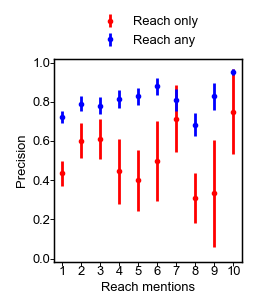

In [23]:
# Figure 5D: Correctness vs. Reach mentions with and without reader overlap
def stderrp(p, n):
    pa = np.array(p)
    na = np.array(n)
    return(np.sqrt((pa*(1-pa))/na))

def reader_corr_vs_overlap(ct_df, reader, legend_loc):
    source_cols = ['medscan', 'reach', 'sparser', 'rlimsp', 'trips', 'hprd', 'isi',
                   'biopax', 'bel', 'signor', 'trrust']
    source_cols.pop(source_cols.index(reader))
    # Reader only dataframe
    ro_df = ct_df[~ct_df[source_cols].any(axis=1)]
    x = list(range(1, 11))
    r_only = []
    r_all = []
    r_only_cts = []
    r_all_cts = []

    for i in x:
        # Upper and lower bound for this group of counts: 1-9 and then 10+
        lb = i
        ub = i+1 if i < 10 else 10000

        r_only_rows = ro_df[(ro_df[reader] >= lb) & (ro_df[reader] < ub)]
        r_only.append(r_only_rows['correct'].mean())
        r_only_cts.append(len(r_only_rows['correct']))
        r_all_rows = kge_df[(kge_df[reader] >= lb) & (kge_df[reader] < ub)]
        r_all.append(r_all_rows['correct'].mean())
        r_all_cts.append(len(r_all_rows['correct']))

    fig = plt.figure(figsize=(2, 2.2), dpi=150)
    plt.errorbar(x, r_only, linestyle='', yerr=stderrp(r_only, r_only_cts), marker='o',
                 markersize=2, color='r', label=f'{reader.capitalize()} only')
    plt.errorbar(x, r_all, linestyle='', yerr=stderrp(r_all, r_all_cts), marker='o',
                 markersize=2, color='b', label=f'{reader.capitalize()} any')
    plt.legend(fontsize=fontsize, frameon=False, bbox_to_anchor=legend_loc)
    plt.ylabel('Precision')
    plt.xlabel(f'{reader.capitalize()} mentions')
    plt.ylim([-0.02, 1.02])
    ax = plt.gca()
    format_axis(ax)
    plt.xticks(x)
    plt.subplots_adjust(left=0.2, top=0.8)
    return fig

fig = reader_corr_vs_overlap(kge_df, 'reach', (0.167, 1))
fig.savefig(fig_path('reach_only_corr', 'pdf'))

<IPython.core.display.Javascript object>


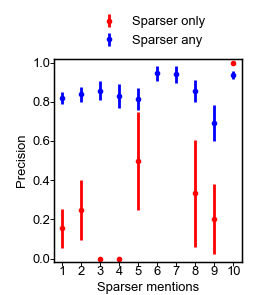

In [24]:
# Figure 5D: Correctness vs. Sparser mentions with and without reader overlap
fig = reader_corr_vs_overlap(kge_df, 'sparser', (0.16, 1))
fig.savefig(fig_path('sparser_only_corr', 'pdf'))